# Dataset Complexity Analysis

This notebook explores the Random Forest complexity metrics contained in ``forest_report.json``. It replicates the logic used by ``sort_datasets_by_complexity.py`` and enriches it with tabular views and visualisations to better understand how each dataset compares.

## Load the dataset report

The JSON report is generated by ``dataset_forest_report.py``. Each entry contains metadata about the dataset alongside summary statistics for the optimised Random Forest model.

In [3]:
from __future__ import annotations

from pathlib import Path
from typing import Any, Mapping
import json

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
REPORT_PATH = Path('forest_report.json')
REPORT_PATH.resolve()

WindowsPath('C:/Users/danie/Projects/GitHub/icde/forest_report.json')

In [4]:
with REPORT_PATH.open('r', encoding='utf-8') as handle:
    report_data: list[dict[str, Any]] = json.load(handle)

len(report_data)

87

## Build a summary table

We reuse the Random Forest estimator counts reported in ``forest_report.json`` to build a sortable summary. This mirrors the CLI behaviour after switching to raw estimator counts.

In [5]:
def to_int(value: Any | None) -> int | None:
    try:
        return int(value)
    except (TypeError, ValueError):
        return None

def to_float(value: Any | None) -> float | None:
    try:
        return float(value)
    except (TypeError, ValueError):
        return None

def extract_metadata(entry: Mapping[str, Any]) -> dict[str, Any]:
    metadata = entry.get('metadata')
    if not isinstance(metadata, Mapping):
        metadata = {}

    statistics = entry.get('forest_statistics')
    if not isinstance(statistics, Mapping):
        statistics = {}

    dataset = str(entry.get('dataset', '')) or '<unknown>'

    return {
        'dataset': dataset,
        'n_estimators': to_int(statistics.get('n_estimators')),
        'series_length': to_int(metadata.get('series_length')),
        'train_size': to_int(metadata.get('train_size')),
        'test_size': to_int(metadata.get('test_size')),
        'avg_depth': to_float(statistics.get('avg_depth')),
        'avg_leaves': to_float(statistics.get('avg_leaves')),
        'avg_nodes': to_float(statistics.get('avg_nodes')),
    }

summary_rows = [extract_metadata(entry) for entry in report_data]
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(['n_estimators', 'series_length', 'dataset'], ascending=[False, False, True], na_position='last').reset_index(drop=True)
summary_df.head()

,dataset,forest_dimension,series_length,train_size,test_size,avg_depth,avg_leaves,avg_nodes,n_estimators
0,UWaveGestureLibraryX,59620.0,315,896,3582,11.410000,99.866667,198.733333,300.0
1,WordSynonyms,43314.0,270,267,638,8.956667,72.690000,144.380000,300.0
2,UWaveGestureLibraryZ,32193.0,315,896,3582,12.840491,99.251534,197.503067,163.0
3,UWaveGestureLibraryY,30722.0,315,896,3582,10.850000,51.703333,102.406667,300.0
4,CricketY,25746.0,300,390,390,7.843333,43.410000,85.820000,300.0


## Full dataset ranking

The full table mirrors the CLI output but includes additional metadata for reference.

In [6]:
styled_summary = summary_df.style.format({
    'n_estimators': '{:,}'.format,
    'avg_depth': '{:.2f}'.format,
    'avg_leaves': '{:,.2f}'.format,
    'avg_nodes': '{:,.2f}'.format,
})
styled_summary

,dataset,forest_dimension,series_length,train_size,test_size,avg_depth,avg_leaves,avg_nodes,n_estimators
0,UWaveGestureLibraryX,"59,620.00",315,896,3582,11.41,99.87,198.73,300.000000
1,WordSynonyms,"43,314.00",270,267,638,8.96,72.69,144.38,300.000000
2,UWaveGestureLibraryZ,"32,193.00",315,896,3582,12.84,99.25,197.50,163.000000
3,UWaveGestureLibraryY,"30,722.00",315,896,3582,10.85,51.70,102.41,300.000000
4,CricketY,"25,746.00",300,390,390,7.84,43.41,85.82,300.000000
5,FiftyWords,"25,468.00",270,450,455,7.21,44.41,87.82,290.000000
6,NonInvasiveFetalECGThorax1,"21,677.00",750,1800,1965,8.20,60.38,119.76,181.000000
7,MixedShapesRegularTrain,"15,721.00",1024,500,2425,9.65,31.82,62.63,251.000000
8,DistalPhalanxOutlineCorrect,"15,438.00",80,600,276,9.98,26.23,51.46,300.000000
9,LargeKitchenAppliances,"14,399.00",720,375,375,10.03,33.68,66.35,217.000000


## Top datasets by estimator count

A horizontal bar chart provides a compact overview of the datasets with the largest ensembles.

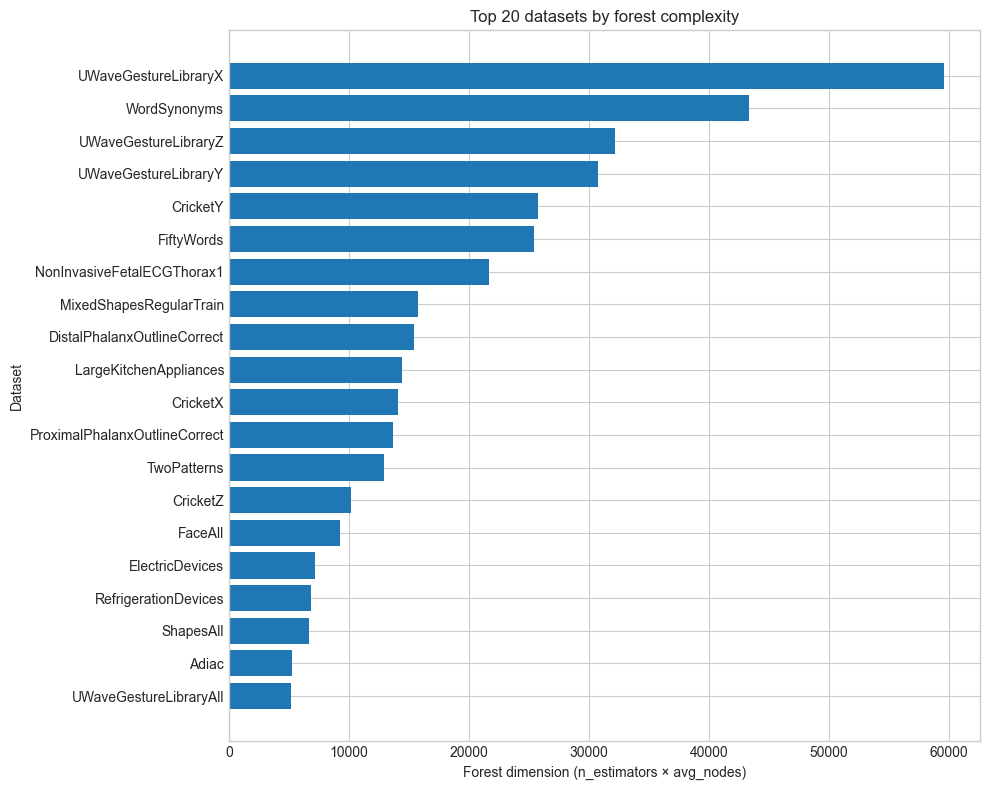

In [7]:
top_n = 20
top_complex = summary_df.head(top_n)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_complex['dataset'], top_complex['n_estimators'], color='#1f77b4')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Dataset')
ax.set_title(f'Top {top_n} datasets by estimator count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Estimator count vs. series length

The scatter plot below highlights whether longer time series also require larger ensembles.

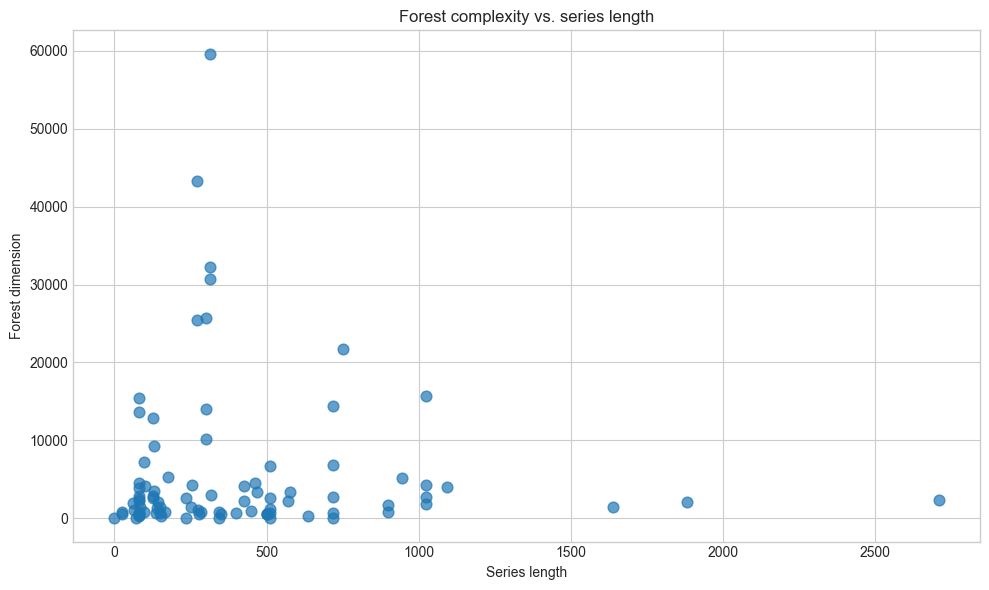

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(summary_df['series_length'], summary_df['n_estimators'], s=60, alpha=0.7)
ax.set_xlabel('Series length')
ax.set_ylabel('Number of estimators')
ax.set_title('Estimator count vs. series length')
plt.tight_layout()
plt.show()

## Distribution of estimator counts

Finally, a histogram shows how estimator usage varies across datasets.

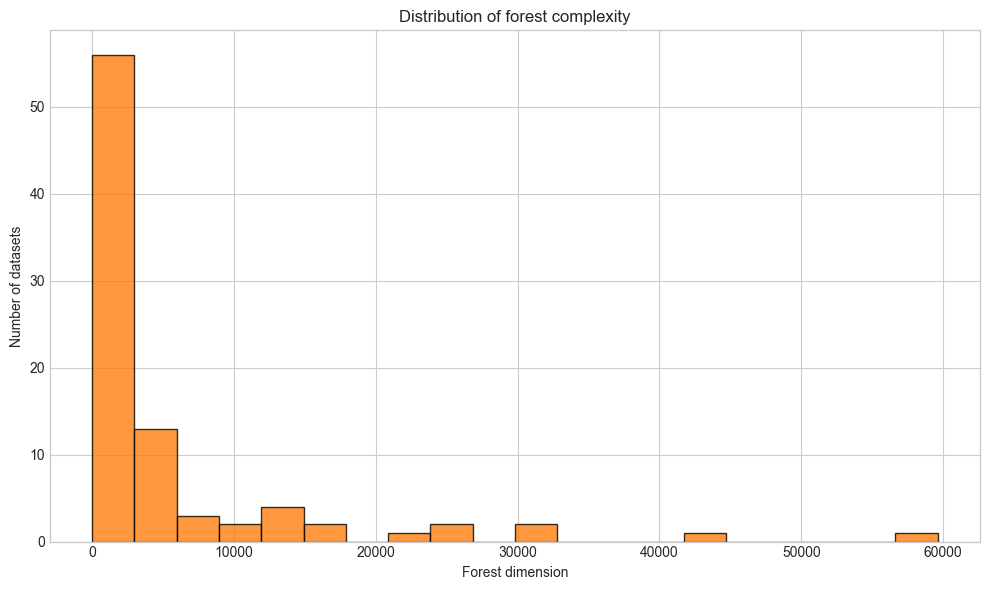

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(summary_df['n_estimators'], bins=20, color='#ff7f0e', edgecolor='black', alpha=0.8)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Number of datasets')
ax.set_title('Distribution of estimator counts')
plt.tight_layout()
plt.show()